# Cross-lingual Word Embeddings

We give here a brief introduction of the concepts and methods that can learn joint word embeddings for multiple languages.

In the previous notebook we described how one can learn word embeddings from mono-lingual corpora. These mono-lingual word embeddings capture the particularities of the specific language but they cannot used in other languages. For example, we would like to leverage high resource languages like English in order to enable downstream tasks in low resource languages. To do so, one should learn word embeddings of different languages in a common space.

Let's see how word embeddings learned in a common space look like. For this purpose we will use the ConceptNet multilingual embeddings for English and French. 

In [9]:
import sys
sys.path.append('../')
from utils import load_embeddings,emb2numpy
from sklearn.manifold import TSNE
from IPython.display import Image
import numpy as np

In [6]:
en_emb = load_embeddings(path="/home/ipartalas/NLP/sentiment_classification/embeddings/concept_net_1706.300.en", dimension=300,skip_header=False,vocab=None)
fr_emb = load_embeddings(path="/home/ipartalas/NLP/sentiment_classification/embeddings/concept_net_1706.300.fr", dimension=300,skip_header=False,vocab=None)

Loaded 417194 vectors
Loaded 296986 vectors


In [7]:
words_en,V_en = emb2numpy(en_emb)
words_fr,V_fr = emb2numpy(en_emb)

In [53]:
mask_en = np.isin(words_en,["room","hotel","towel","book","coffee","chair","glass","pen","shoe","two","amazing"])
mask_fr = np.isin(words_fr,["hôtel","chambre","livre","café","chaise","serviette","verre","stylo","chaussure","deux","fantastique"])

In [54]:
#indices = np.where(mask)[0]
indices_en = np.where(mask_en)[0]
indices_fr = np.where(mask_fr)[0]
vectors = np.concatenate((V_en[indices_en],V_fr[indices_fr]))
all_words = np.array(words_en)[indices_en].tolist()+np.array(words_fr)[indices_fr].tolist()

In [55]:
all_words

['amazing',
 'book',
 'chair',
 'coffee',
 'glass',
 'hotel',
 'pen',
 'room',
 'shoe',
 'towel',
 'two',
 'café',
 'chaussure',
 'chambre',
 'chaise',
 'deux',
 'fantastique',
 'hôtel',
 'livre',
 'serviette',
 'stylo',
 'verre']

In [56]:
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP

# We project the 300d vectors to a 2d space for visualization
V_umap = UMAP(n_neighbors=3,min_dist=0.1).fit_transform(vectors)


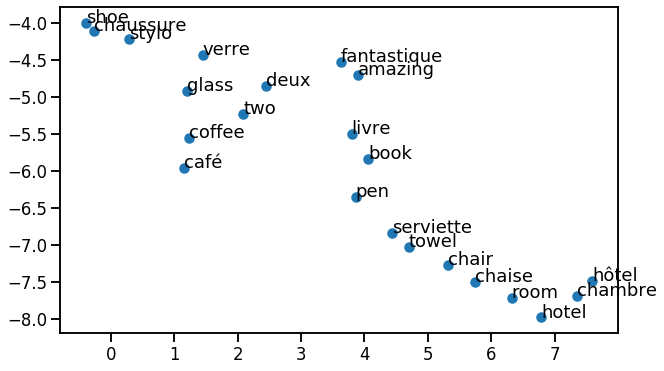

In [57]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

fig= plt.figure(figsize=(10,6))

plt.scatter(V_umap[:, 0], V_umap[:, 1])
for i, word in enumerate(all_words):
    plt.annotate(word, xy=(V_umap[i, 0], V_umap[i, 1]))
plt.show()

You can observe that the words from the different languages are close in the embeddings space.

Several methods for learning such cross-lingual embeddings have been proposed recently. They most straightforward ones try to align mono-lingual embeddings which has been learned seperately. In order to so, some sort of supervision is required which may be for example in the form of a bilingual dictionary or sentence-aligned data.

The following figure presents schemetically the approach of mono-lingual mapping.

![](../data/images/alignment.png)

# Sentence Embeddings